In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2_video_predictor

In [3]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [5]:
checkpoint = "../sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, checkpoint)

In [7]:
# util functions

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

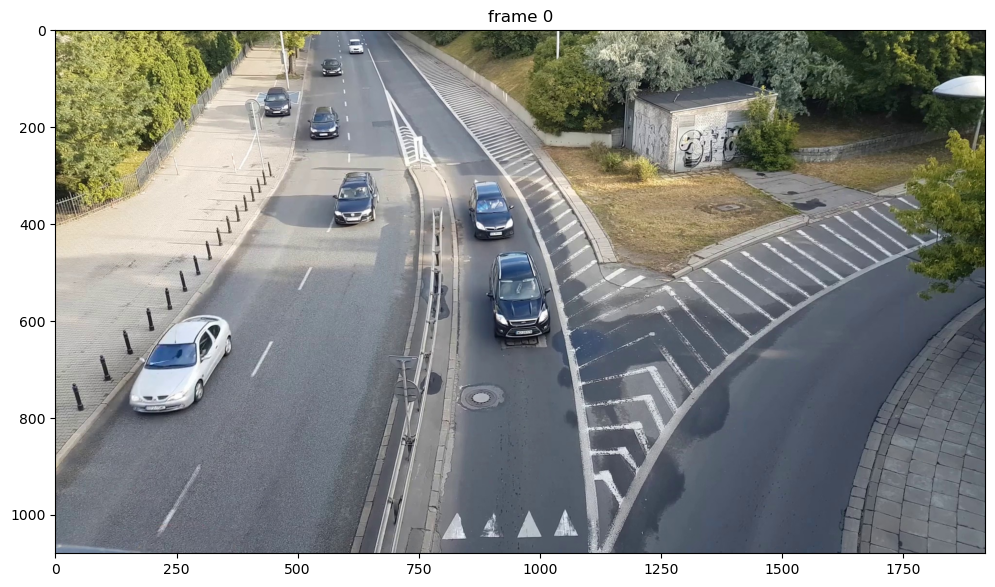

In [9]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "../road_video_frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [11]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 21.26it/s]


---

## Segmenting specific point in frame

/home/eld4niz/anaconda3/lib/python3.12/site-packages/sam2/sam2_video_predictor.py:869: UserWarning: cannot import name '_C' from 'sam2' (/home/eld4niz/anaconda3/lib/python3.12/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. Consider building SAM 2 with CUDA extension to enable post-processing (see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


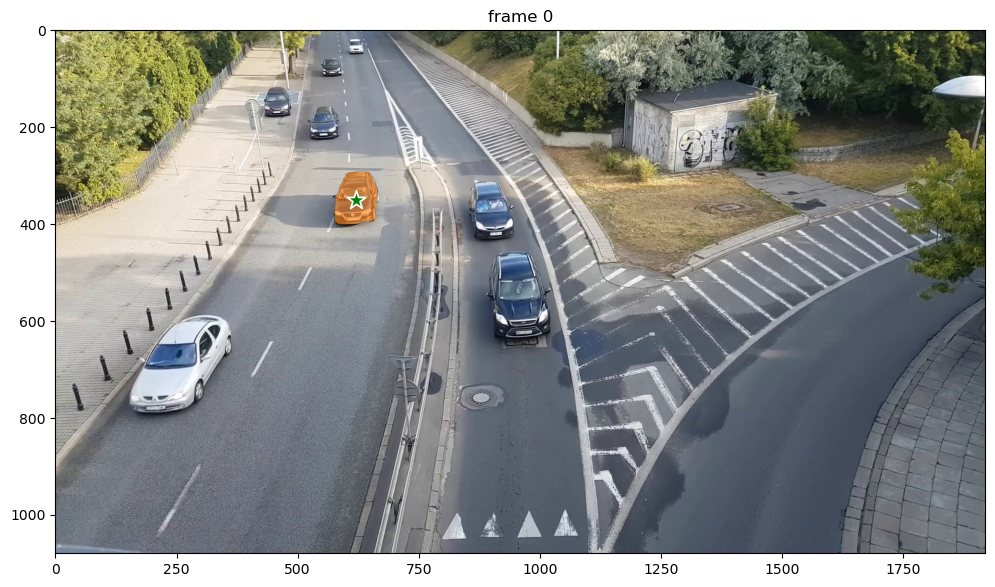

In [15]:
specific_frame = 0 
ann_obj_id = 1

points = np.array([[620, 350]], dtype=np.float32)

labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=specific_frame,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)


plt.figure(figsize=(12, 8))
plt.title(f"frame {specific_frame}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[specific_frame])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

---

## Segment Two Vehicles From One Frame

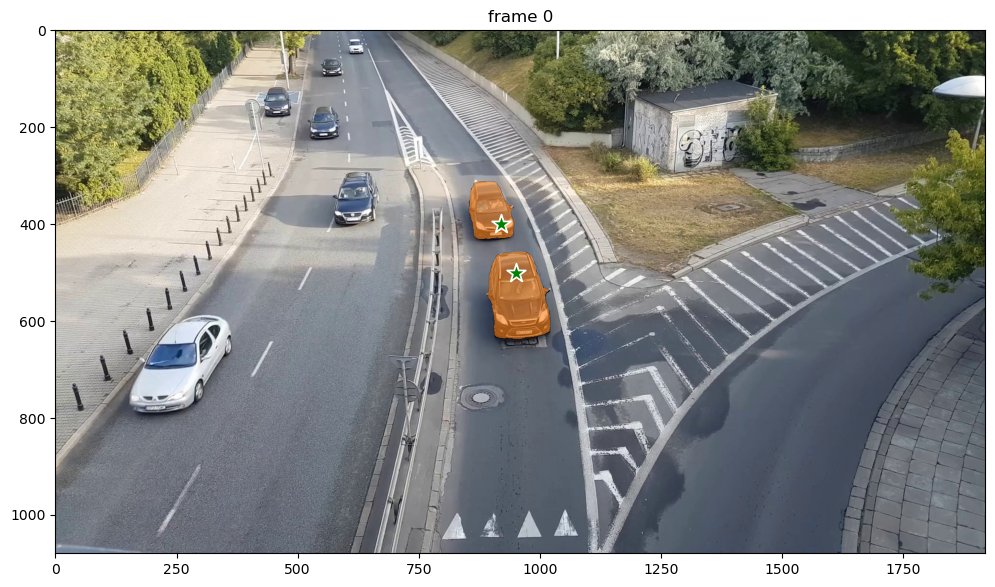

In [19]:
ann_frame_idx = 0
ann_obj_id = 1

points = np.array([[950, 500], [920, 400]], dtype=np.float32)

labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

---

## Detecting Multiple Frames

propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:31<00:00,  4.25it/s]


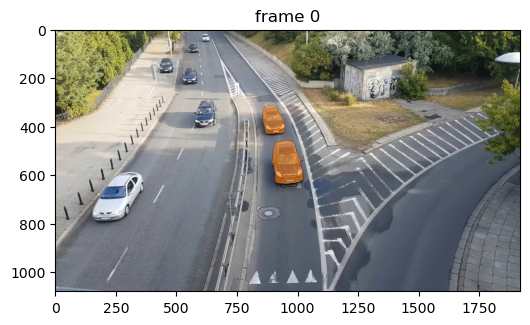

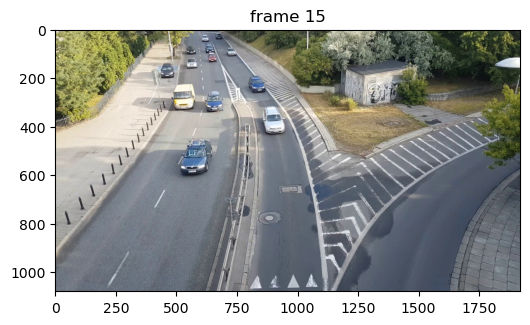

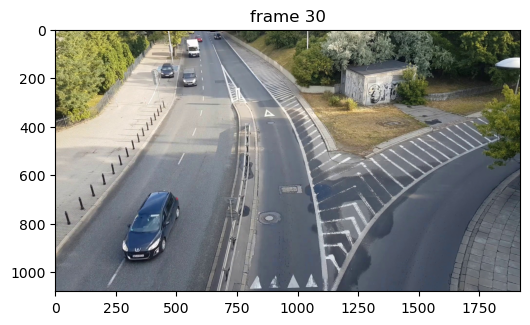

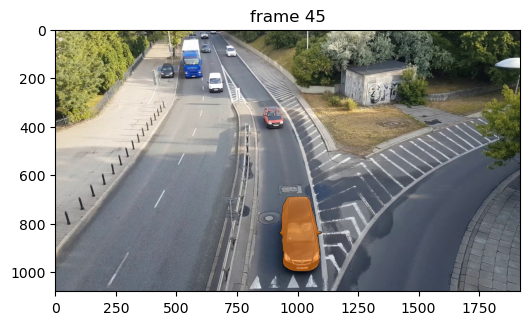

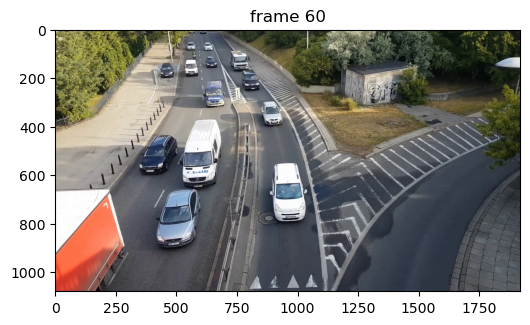

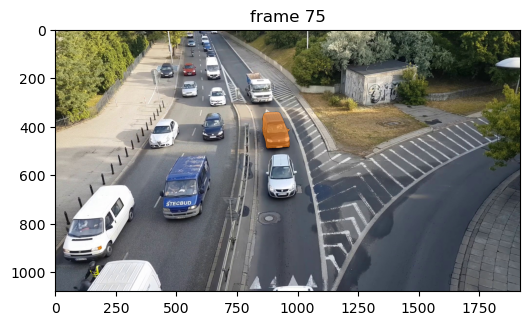

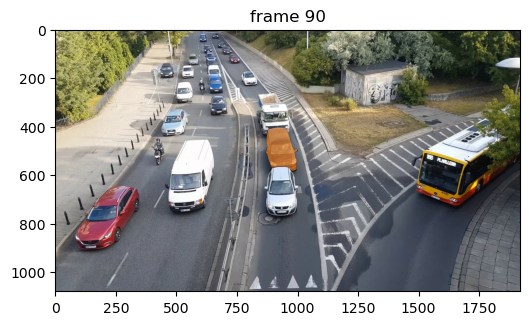

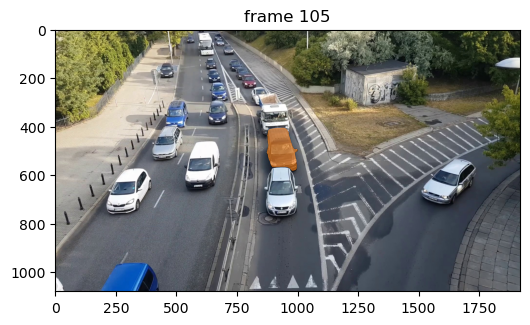

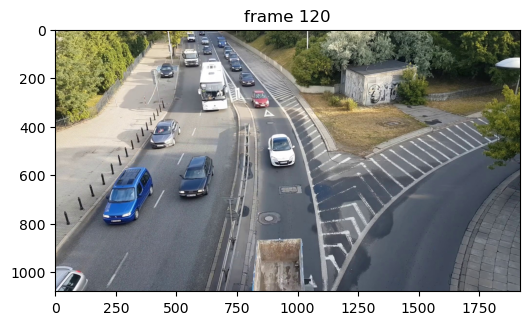

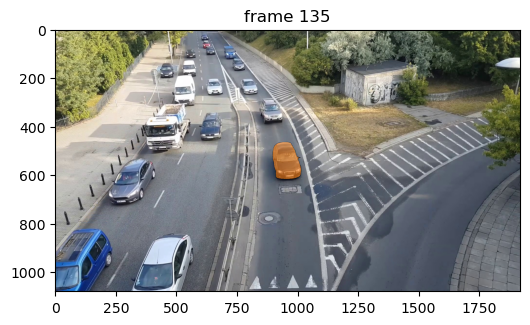

In [23]:
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)